In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import os
import keras
from keras.callbacks import ModelCheckpoint

In [13]:
# Data augmentation
labels = os.listdir('F:/input/oct2017/OCT2017_/train/')
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                                   validation_split=0.2)

In [14]:
IMG_SIZE = 224
batch_size = 16
train_data_dir = 'F:/input/oct2017/OCT2017_/train'
validation_data_dir = 'F:/input/oct2017/OCT2017_/val'
test_data_dir = 'F:/input/oct2017/OCT2017_/test'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    class_mode='categorical')
valid_X, valid_Y = next(train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=4000,
    class_mode='categorical'))

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


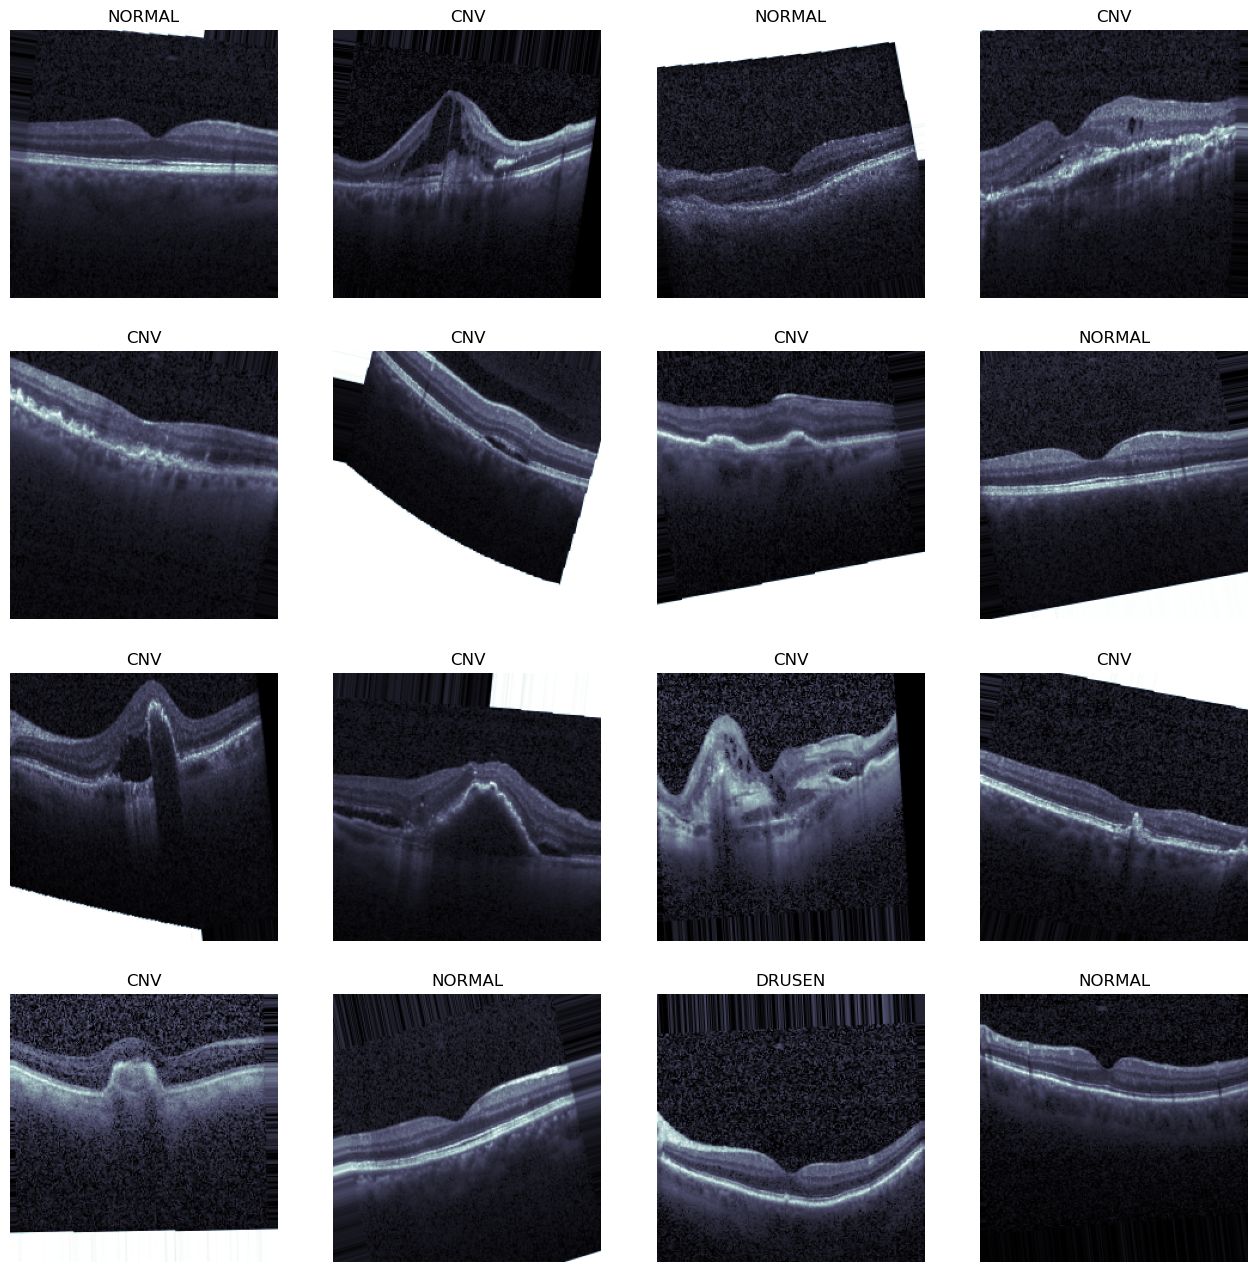

In [15]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [16]:
# Defining ResNet model
def resnet_model():
    img_in = Input(t_x.shape[1:])              #input of model 
    model = ResNet50(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 
    x = model.output  
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [17]:
# compiling model
model = resnet_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

In [18]:
# creating checkpoint
# filepath="weights.best.hdf5"
filepath="D:/cssoftware/retinalOCT_model/resnet_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
# training model
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=100,
                                  validation_data = (valid_X,valid_Y), 
                                  epochs = 3,
                                  callbacks=callbacks_list)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33264\3656843221.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/3
100/100 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.6550
Epoch 1: val_accuracy improved from -inf to 0.32600, saving model to D:/cssoftware/retinalOCT_model\resnet_best.h5
100/100 [==============================] - 651s 6s/step - loss: 1.1300 - accuracy: 0.6550 - val_loss: 1.4521 - val_accuracy: 0.3260
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.7250
Epoch 2: val_accuracy improved from 0.32600 to 0.43025, saving model to D:/cssoftware/retinalOCT_model\resnet_best.h5
100/100 [==============================] - 481s 5s/step - loss: 0.7715 - accuracy: 0.7250 - val_loss: 1.3778 - val_accuracy: 0.4302
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.8087
Epoch 3: val_accuracy did not improve from 0.43025
100/100 [==============================] - 479s 5s/step - loss: 0.5812 - accuracy: 0.8087 - val_loss: 24.4180 - val_accuracy: 0.3210


In [25]:
# loading the model with best weight
model = resnet_model()
model.load_weights(filepath)

In [22]:
# creating test data
test_X, test_Y = next(train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=8000,
    class_mode='categorical'))

Found 16696 images belonging to 4 classes.


In [23]:
# predicting y value
y_pred = model.predict(test_X)

250/250 [==============================] - 336s 1s/step


In [27]:
import numpy as np
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

In [28]:
actual_class = []
for i in range(len(test_Y)):
    actual_class.append(np.argmax(test_Y[i]))

In [29]:
# accuracy score
from sklearn.metrics import accuracy_score
print('accuracy = ',accuracy_score(pred_class,actual_class))

accuracy =  0.444625


In [30]:
# defining confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33264\1641255229.py:24: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


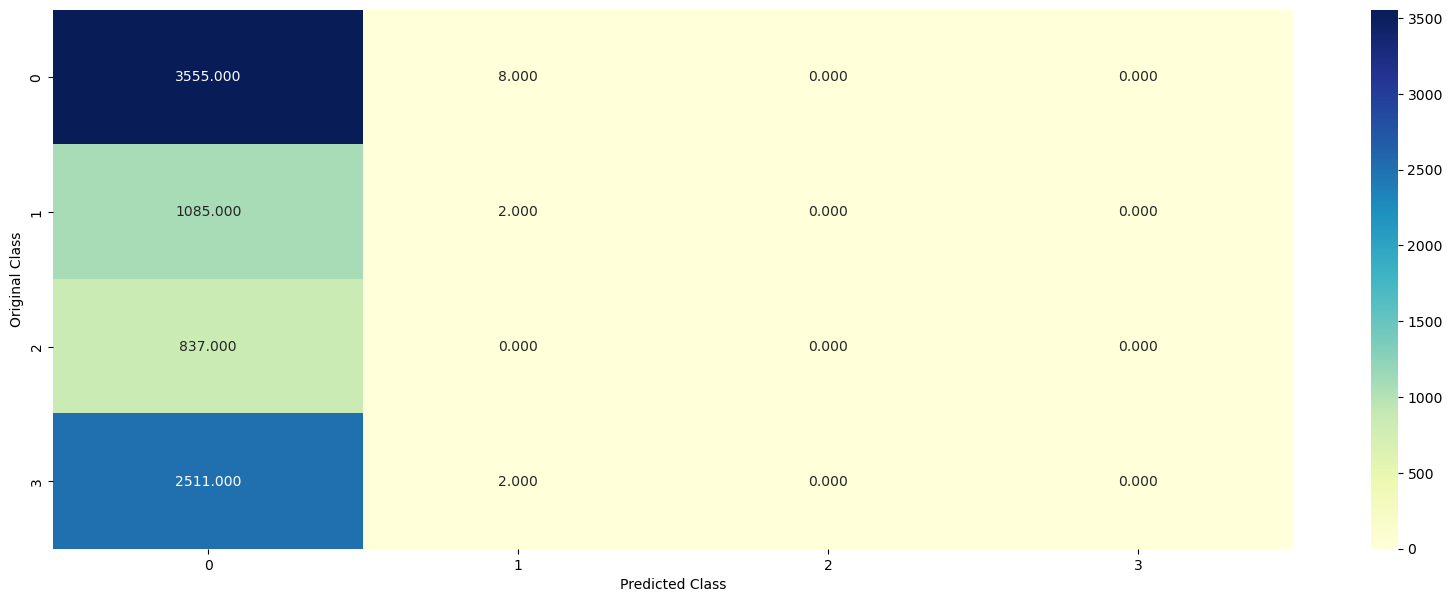

-------------------- Precision matrix (Columm Sum=1) --------------------


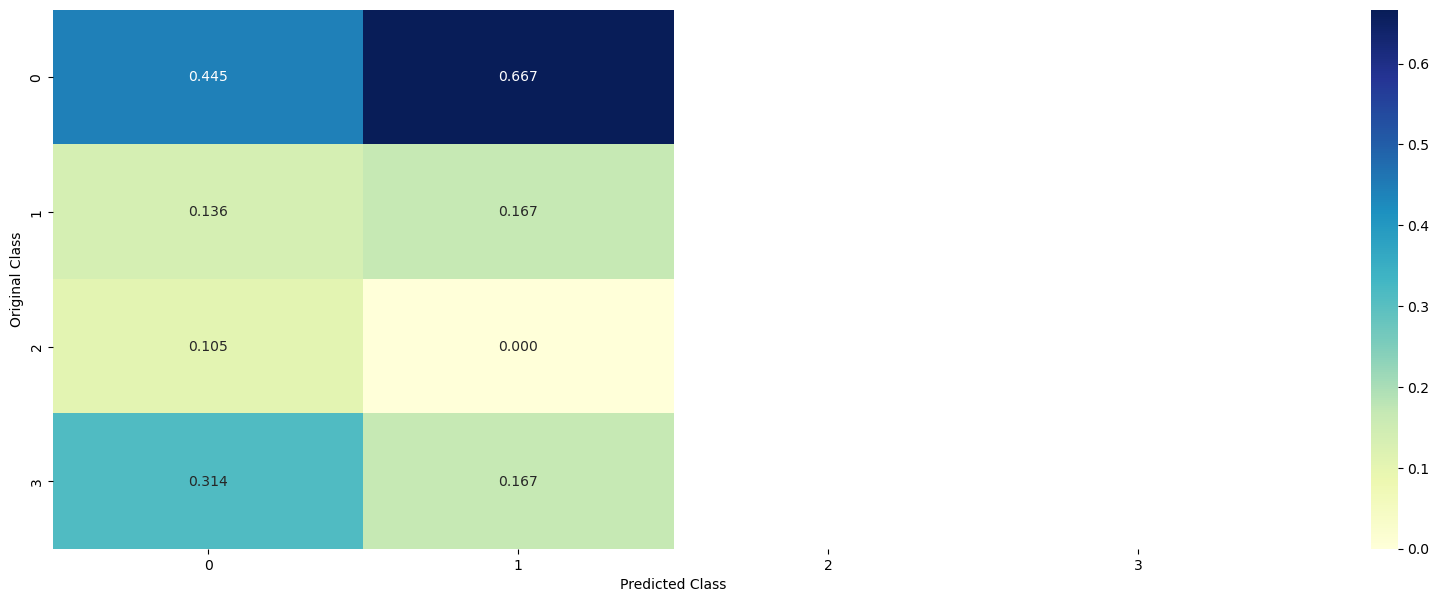

-------------------- Recall matrix (Row sum=1) --------------------


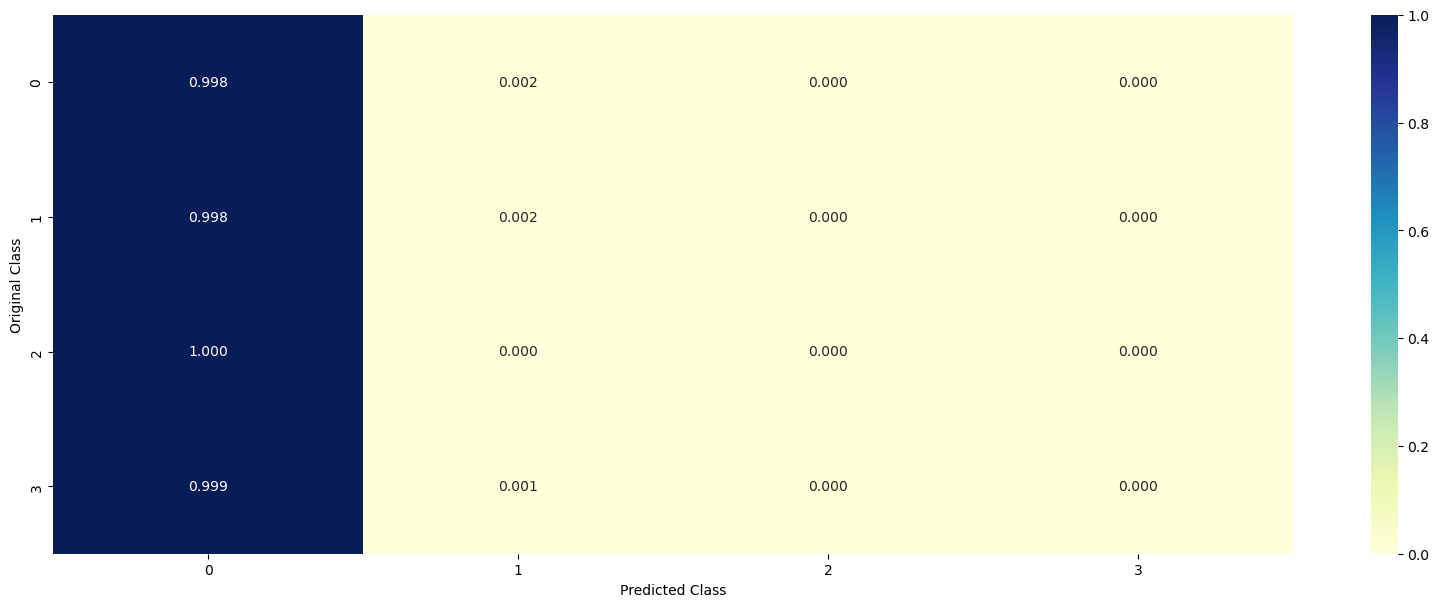

In [31]:
plot_confusion_matrix(actual_class,pred_class)